In [7]:
!pip install tf-keras


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!pip install vaderSentiment


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement RoBerta (from versions: none)
ERROR: No matching distribution found for RoBerta


Using device: mps
Loading RoBERTa model...
Loading VADER analyzer...
Reading data...

Analyzing reviews...


Processing reviews: 100%|██████████| 53/53 [00:31<00:00,  1.68it/s]



Generating comparison statistics...

Calculating word sentiments...


Processing words: 100%|██████████| 297/297 [00:06<00:00, 47.32it/s]



Generating word clouds...


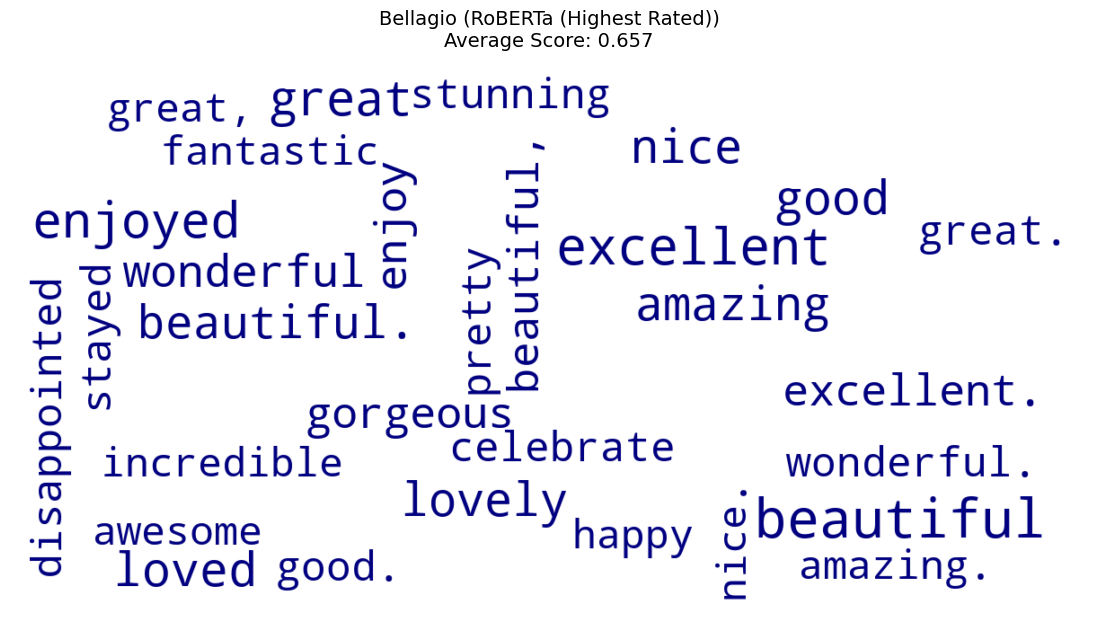

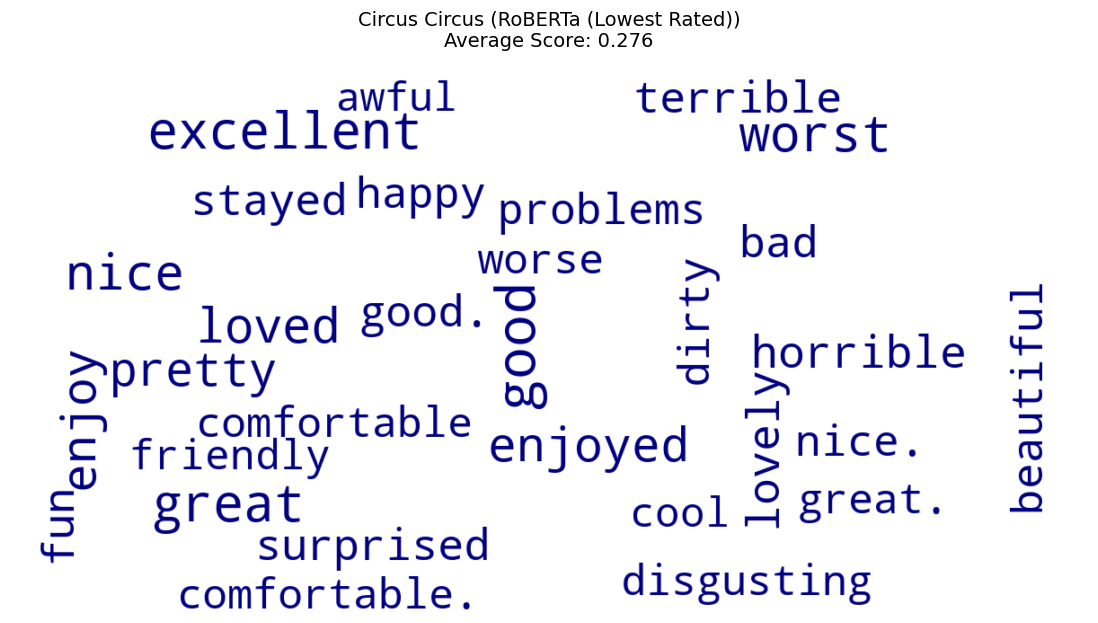

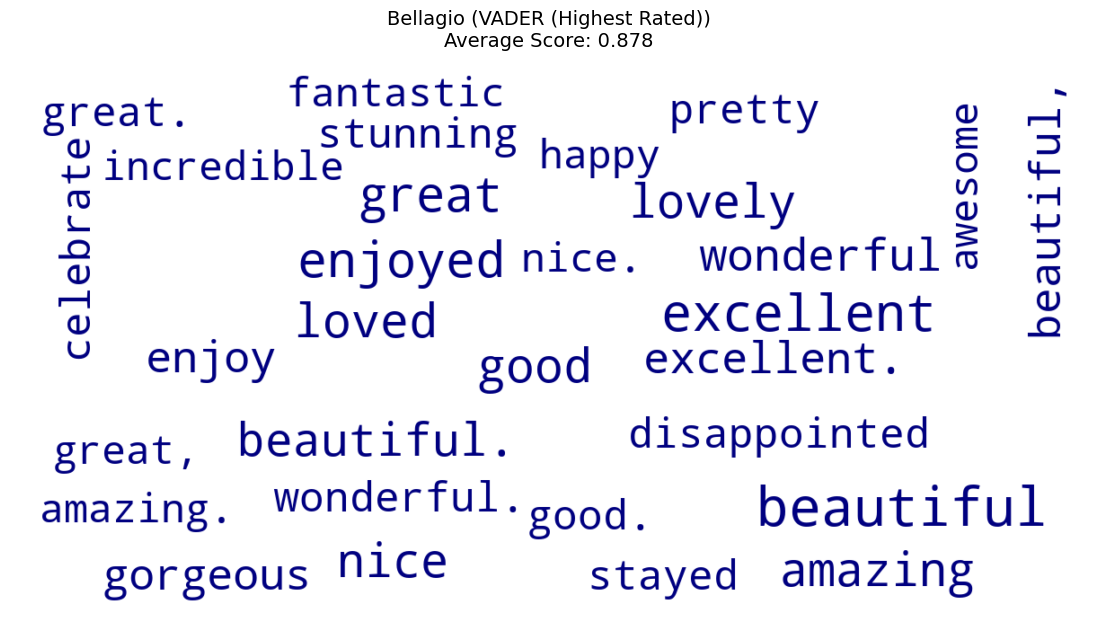

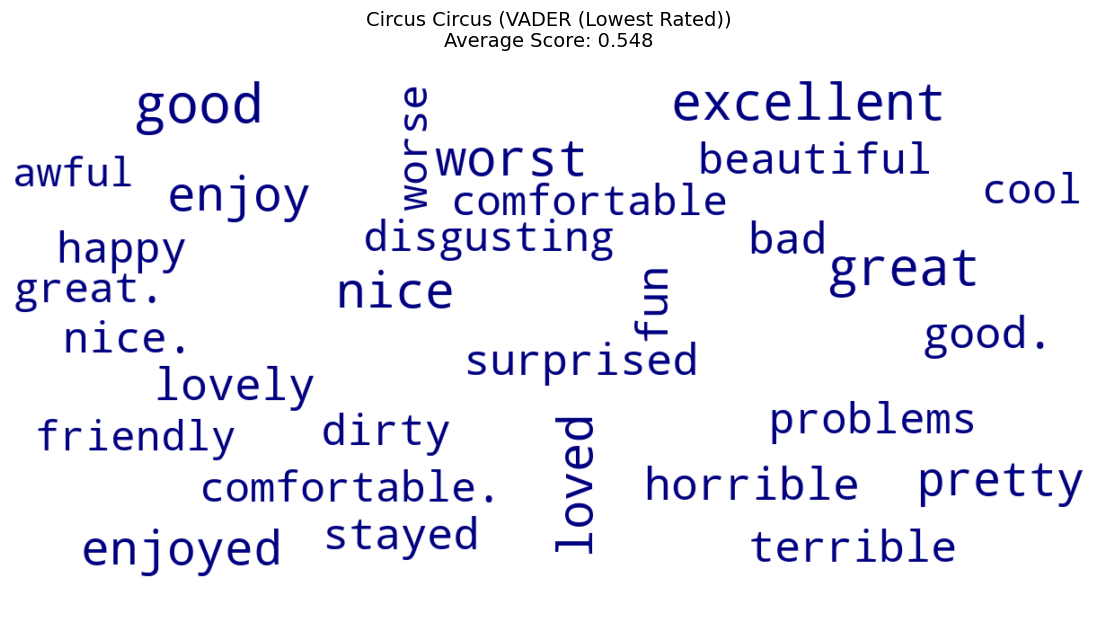


=== Sentiment Analysis Comparison Results ===

Correlation between RoBERTa and VADER scores: 0.716

Hotels with Largest Scoring Differences:
               RoBERTa_Mean  VADER_Mean  Score_Difference
hotel                                                    
Excalibur             0.393       0.712             0.319
Circus Circus         0.276       0.548             0.272
Encore                0.501       0.772             0.271
Bally's               0.483       0.715             0.232
Bellagio              0.657       0.878             0.221

Saving results to Excel...


In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SentimentAnalyzer:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.device = self.get_device()
        print(f"Using device: {self.device}")
        
        print("Loading RoBERTa model...")
        model_name = "cardiffnlp/twitter-roberta-base-sentiment"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model = self.model.to(self.device)
        self.model.eval()  # Set to evaluation mode
        
        print("Loading VADER analyzer...")
        self.vader = SentimentIntensityAnalyzer()
        
    def get_device(self):
        if torch.backends.mps.is_available():
            return torch.device("mps")
        elif torch.cuda.is_available():
            return torch.device("cuda")
        return torch.device("cpu")

    def process_batch(self, texts):
        """Process a batch of texts with RoBERTa"""
        inputs = self.tokenizer(
            texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
            # Convert to scores between -1 and 1
            return (scores[:, 2] - scores[:, 0]).cpu().numpy()

    def analyze_texts(self, texts):
        """Analyze a list of texts in batches"""
        roberta_scores = []
        vader_scores = []
        
        # Process in batches
        for i in tqdm(range(0, len(texts), self.batch_size), desc="Processing reviews"):
            batch_texts = texts[i:i + self.batch_size]
            
            # RoBERTa sentiment
            roberta_batch_scores = self.process_batch(batch_texts)
            roberta_scores.extend(roberta_batch_scores)
            
            # VADER sentiment
            vader_batch_scores = [self.vader.polarity_scores(text)['compound'] 
                                for text in batch_texts]
            vader_scores.extend(vader_batch_scores)
        
        return roberta_scores, vader_scores

    def create_wordcloud(self, hotel_reviews, sentiment_scores, title):
        """Create word cloud using pre-calculated sentiment scores"""
        # Combine all reviews for the hotel
        all_text = ' '.join(hotel_reviews)
        words_list = [word.lower() 
                     for word in all_text.split() 
                     if len(word) > 2]
        
        # Count word frequencies
        word_freq = Counter(words_list)
        total_words = len(words_list)
        
        # Remove extreme outliers
        threshold = total_words * 0.01  
        
        # Calculate normalized word importance scores
        word_scores = {}
        for word, freq in word_freq.items():
            if freq >= 2:  # Must appear at least twice
                sentiment = abs(sentiment_scores.get(word, 0))
                if sentiment > 0.05:  
                    # Combine frequency and sentiment for importance
                    word_scores[word] = sentiment * np.log1p(freq)
        
        # Keep top 100 words by importance
        word_scores = dict(sorted(word_scores.items(), 
                                key=lambda x: x[1], 
                                reverse=True)[:100])
        
        if not word_scores:
            print(f"Warning: No significant terms found for {title}")
            return
        
        # Create and display word cloud
        wordcloud = WordCloud(
            width=1200, 
            height=600,
            background_color='white',
            max_words=30,  # Increased from 20
            min_font_size=10,
            max_font_size=60,
            color_func=lambda *args, **kwargs: 'navy'
        ).generate_from_frequencies(word_scores)
        
        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=14, pad=20)
        plt.show()

def main():
    # Initialize analyzer
    analyzer = SentimentAnalyzer(batch_size=32)
    
    # Read data
    print("Reading data...")
    df = pd.read_excel('/Users/humphrjk/Library/CloudStorage/OneDrive-UNTSystem/ADTA 5320/ADTA 5230/ADTA 5230/Data/hotels.xlsx')
    
    # Calculate sentiments for all reviews at once
    print("\nAnalyzing reviews...")
    roberta_scores, vader_scores = analyzer.analyze_texts(df['Review'].tolist())
    
    # Add scores to dataframe
    df['roberta_sentiment'] = roberta_scores
    df['vader_sentiment'] = vader_scores
    
    # Calculate correlation
    correlation = np.corrcoef(roberta_scores, vader_scores)[0, 1]
    
    # Create comparison table
    print("\nGenerating comparison statistics...")
    hotel_stats = df.groupby('hotel').agg({
        'roberta_sentiment': ['mean', 'std'],
        'vader_sentiment': ['mean', 'std'],
        'Review': 'count'
    }).round(3)
    
    hotel_stats.columns = ['RoBERTa_Mean', 'RoBERTa_Std', 'VADER_Mean', 'VADER_Std', 'Review_Count']
    hotel_stats['Score_Difference'] = (hotel_stats['RoBERTa_Mean'] - hotel_stats['VADER_Mean']).abs()
    
    # Sort by each scoring method
    roberta_sorted = hotel_stats.sort_values('RoBERTa_Mean', ascending=False)
    vader_sorted = hotel_stats.sort_values('VADER_Mean', ascending=False)
    
    # Pre-calculate sentiment scores for words
    print("\nCalculating word sentiments...")
    word_sentiments = {}
    
    # Collect words that appear more than once
    word_freq = Counter(word.lower() 
                       for review in df['Review'] 
                       for word in review.split() 
                       if len(word) > 2)
    
    unique_words = {word for word, freq in word_freq.items() if freq >= 2}
    
    # Calculate sentiments in batches
    word_batches = [list(unique_words)[i:i + analyzer.batch_size] 
                   for i in range(0, len(unique_words), analyzer.batch_size)]
    
    for batch in tqdm(word_batches, desc="Processing words"):
        roberta_word_scores = analyzer.process_batch(batch)
        for word, score in zip(batch, roberta_word_scores):
            word_sentiments[word] = score
    
    # Generate word clouds with hotel context
    print("\nGenerating word clouds...")
    for sentiment_type, hotel_name, score_col in [
        ("RoBERTa (Highest Rated)", roberta_sorted.index[0], 'roberta_sentiment'),
        ("RoBERTa (Lowest Rated)", roberta_sorted.index[-1], 'roberta_sentiment'),
        ("VADER (Highest Rated)", vader_sorted.index[0], 'vader_sentiment'),
        ("VADER (Lowest Rated)", vader_sorted.index[-1], 'vader_sentiment')
    ]:
        hotel_reviews = df[df['hotel'] == hotel_name]['Review']
        avg_score = df[df['hotel'] == hotel_name][score_col].mean()
        title = f"{hotel_name} ({sentiment_type})\nAverage Score: {avg_score:.3f}"
        analyzer.create_wordcloud(hotel_reviews, word_sentiments, title)
    
    # Print results
    print("\n=== Sentiment Analysis Comparison Results ===")
    print(f"\nCorrelation between RoBERTa and VADER scores: {correlation:.3f}")
    
    print("\nHotels with Largest Scoring Differences:")
    discrepancies = hotel_stats.sort_values('Score_Difference', ascending=False)
    print(discrepancies[['RoBERTa_Mean', 'VADER_Mean', 'Score_Difference']].head())
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Hotel': hotel_stats.index,
        'RoBERTa_Score': hotel_stats['RoBERTa_Mean'],
        'VADER_Score': hotel_stats['VADER_Mean'],
        'Score_Difference': hotel_stats['Score_Difference'],
        'Review_Count': hotel_stats['Review_Count'],
        'RoBERTa_Rank': hotel_stats.index.get_indexer(roberta_sorted.index) + 1,
        'VADER_Rank': hotel_stats.index.get_indexer(vader_sorted.index) + 1
    })
    
    # Save results
    print("\nSaving results to Excel...")
    with pd.ExcelWriter('hotel_sentiment_comparison.xlsx') as writer:
        hotel_stats.to_excel(writer, sheet_name='Hotel_Statistics')
        comparison_df.to_excel(writer, sheet_name='Detailed_Comparison', index=False)
        discrepancies.to_excel(writer, sheet_name='Scoring_Discrepancies')

    # Clean up
    if analyzer.device.type in ["mps", "cuda"]:
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

Using device: mps
Loading RoBERTa model...
Loading Hotel-BERT model...
Loading VADER analyzer...
Reading data...

Analyzing reviews...


Processing reviews: 100%|██████████| 53/53 [00:53<00:00,  1.01s/it]



Calculating word sentiments...


Processing words: 100%|██████████| 297/297 [00:07<00:00, 39.84it/s]



=== Model Correlations ===
            RoBERTa  Hotel-BERT  VADER
RoBERTa       1.000       0.860  0.716
Hotel-BERT    0.860       1.000  0.622
VADER         0.716       0.622  1.000

=== Hotel Rankings and Extreme Reviews ===

RoBERTa Rankings:
               RoBERTa_Mean  Review_Count
hotel                                    
Bellagio              0.657           337
Encore                0.501           334
Bally's               0.483           324
Excalibur             0.393           334
Circus Circus         0.276           342

RoBERTa Extreme Reviews:

Highest Rated Hotel: Bellagio

Top 3 Reviews:
1. [Score: 0.992] Oct 9 2009  Always wonderful! As always the Bellagio was fabulous! Our room was clean and comfortable with an amazing view of the fountain. The staff is exceptional. We dined at Michael Mina for the f...
2. [Score: 0.992] Oct 10 2009  Wonderful hotel We stayed at the Bellagio when we went to Vegas and it was a wonderful choice. The Bellagio is a beautiful hotel with

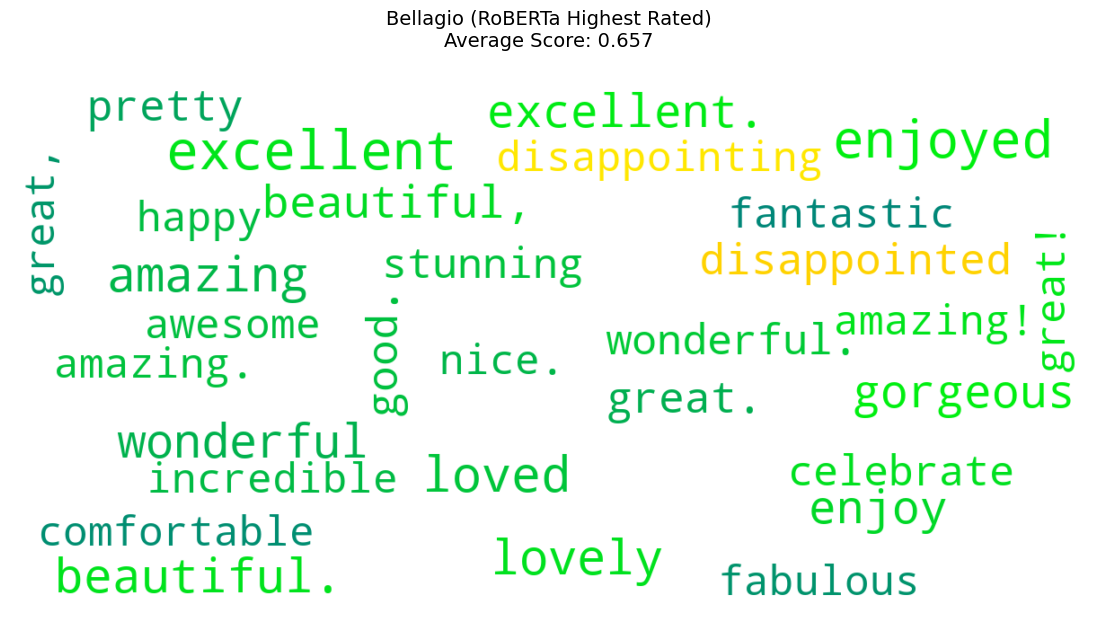

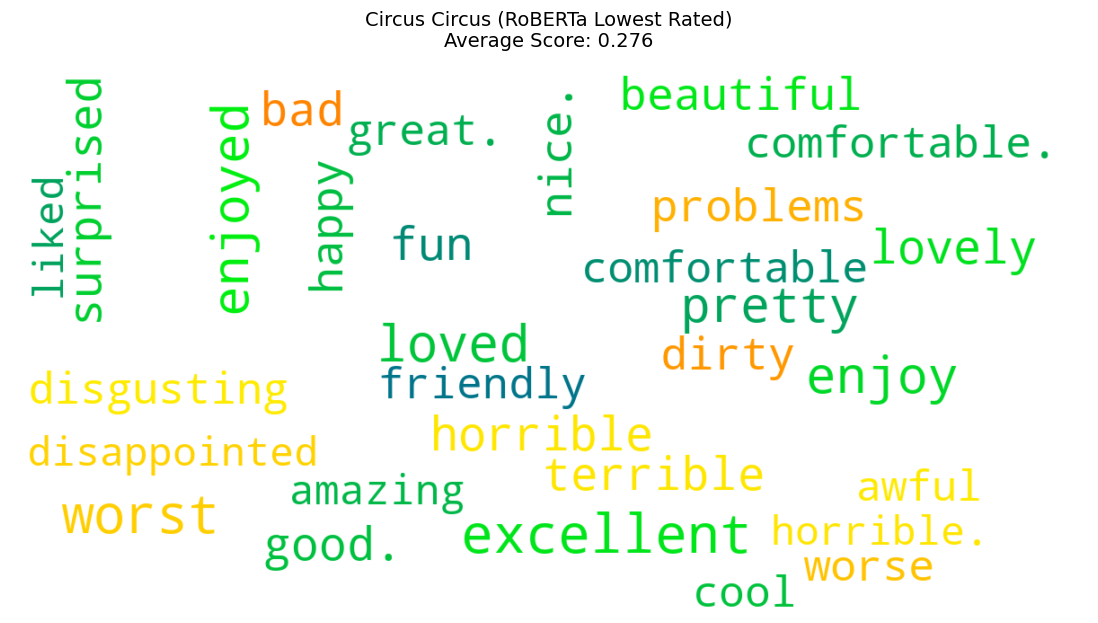


HotelBERT Rankings:
               HotelBERT_Mean  Review_Count
hotel                                      
Bellagio                0.695           337
Encore                  0.652           334
Bally's                 0.628           324
Excalibur               0.568           334
Circus Circus           0.511           342

HotelBERT Extreme Reviews:

Highest Rated Hotel: Bellagio

Top 3 Reviews:
1. [Score: 0.993] Sep 24 2009  Amazing and love it!! We visited Las Vegas for 3 nights and checked in the Bellagio, we were supposed to get a standard double room, but once they knew we were on honeymoon, updated us to...
2. [Score: 0.992] Aug 26 2009  Best Hotel ever! We booked two nights in a Salone suite but were upgraded to a Cypress suite at check-in. The Cypress suite is the most luxurious hotel room i've ever seen. Everything was...
3. [Score: 0.988] Oct 24 2009  Incredible First Class Outstanding I would highly recommend the Bellagio. We had a Penthouse Suite on the 32nd floor. It 

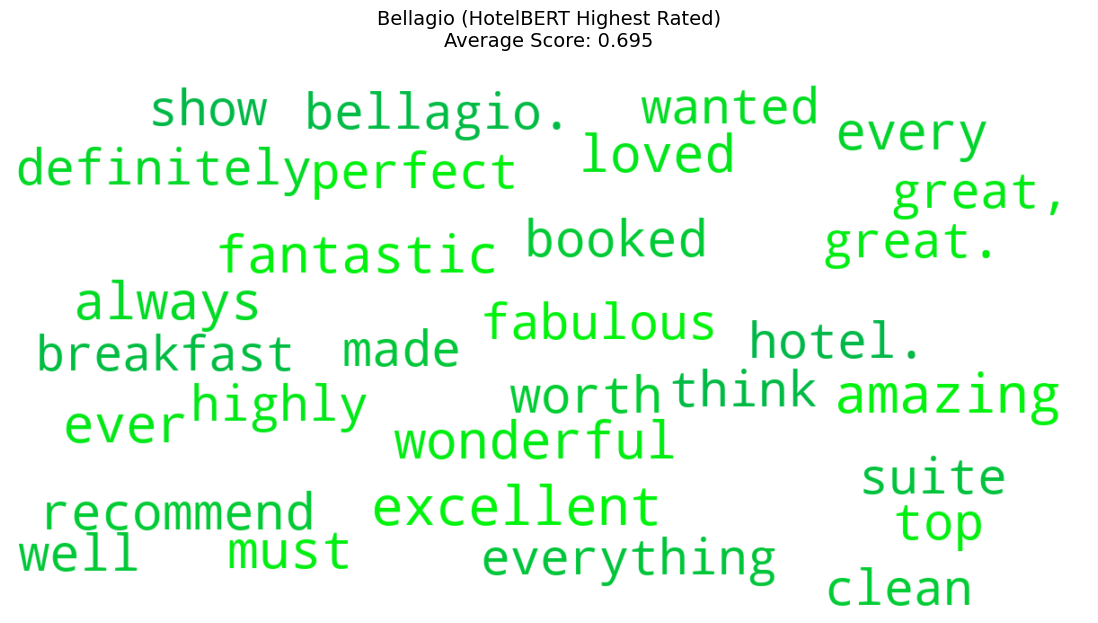

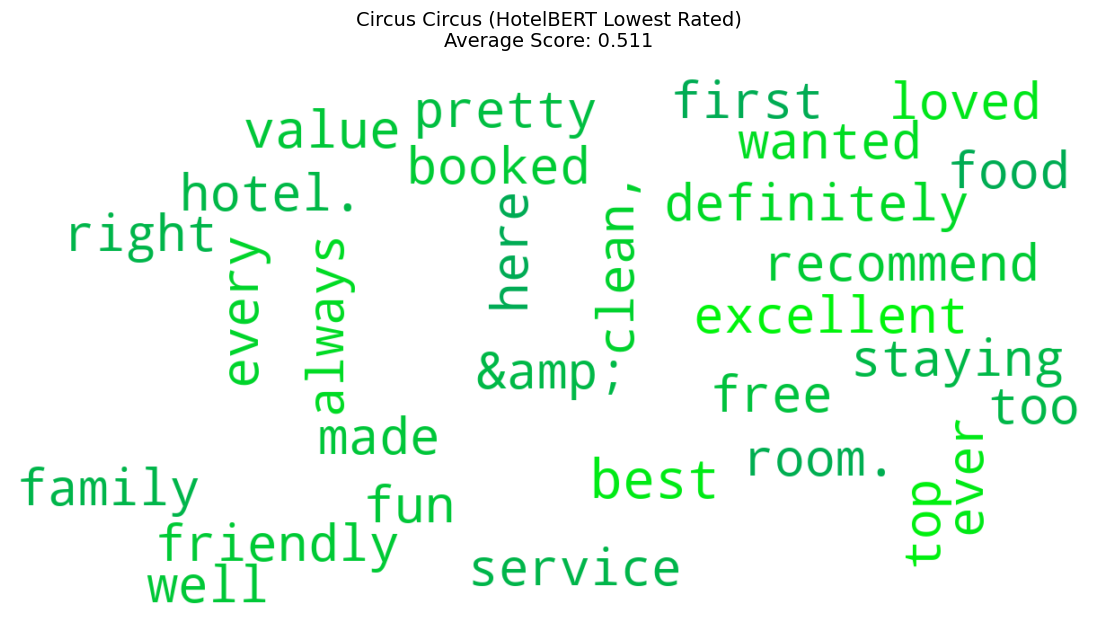


VADER Rankings:
               VADER_Mean  Review_Count
hotel                                  
Bellagio            0.878           337
Encore              0.772           334
Bally's             0.715           324
Excalibur           0.712           334
Circus Circus       0.548           342

VADER Extreme Reviews:

Highest Rated Hotel: Bellagio

Top 3 Reviews:
1. [Score: 1.000]  Can't wait to go back! My husband and I stayed at the Bellagio for one week in November 2009. First of all it is the ultimate spot on the strip. It has the best view (if you get a lakeview room which...
2. [Score: 0.999] Aug 15 2009  Great stay at the bellagio!! Penthouse suite was great Stayed for 6 days at the bellagio at the end of July.Check in. Ver y smooth we were part of the executive level so we were picked up...
3. [Score: 0.999] Jul 31 2009  A Fabulous Experience at Bellagio Just returned from a 3-night get-a-way to Vegas -- a promotional package which included hotel, air and show tickets (reason

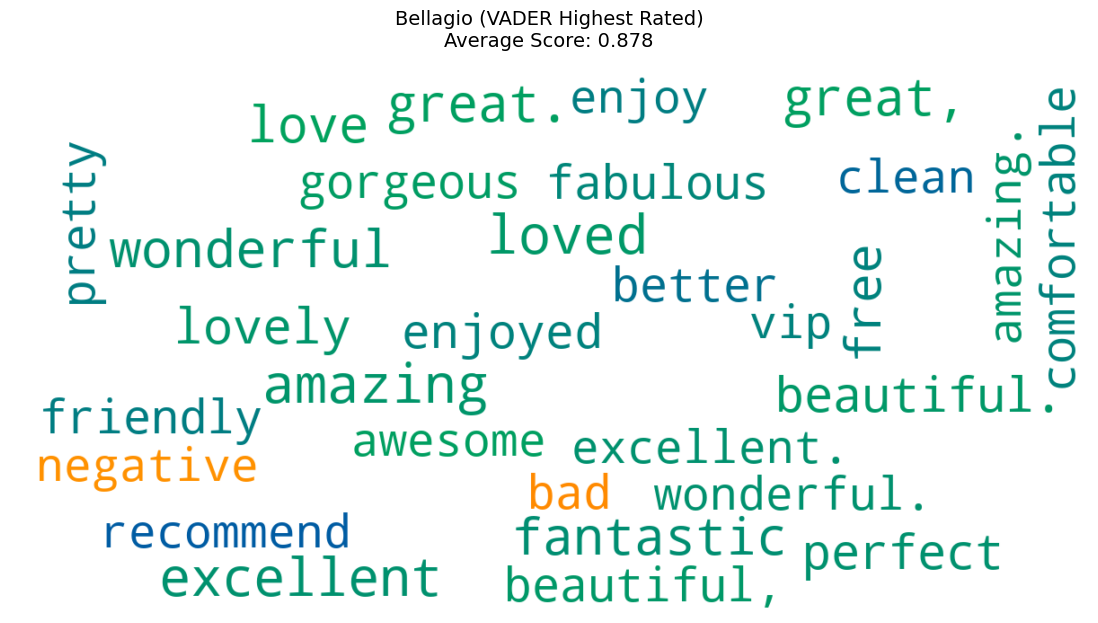

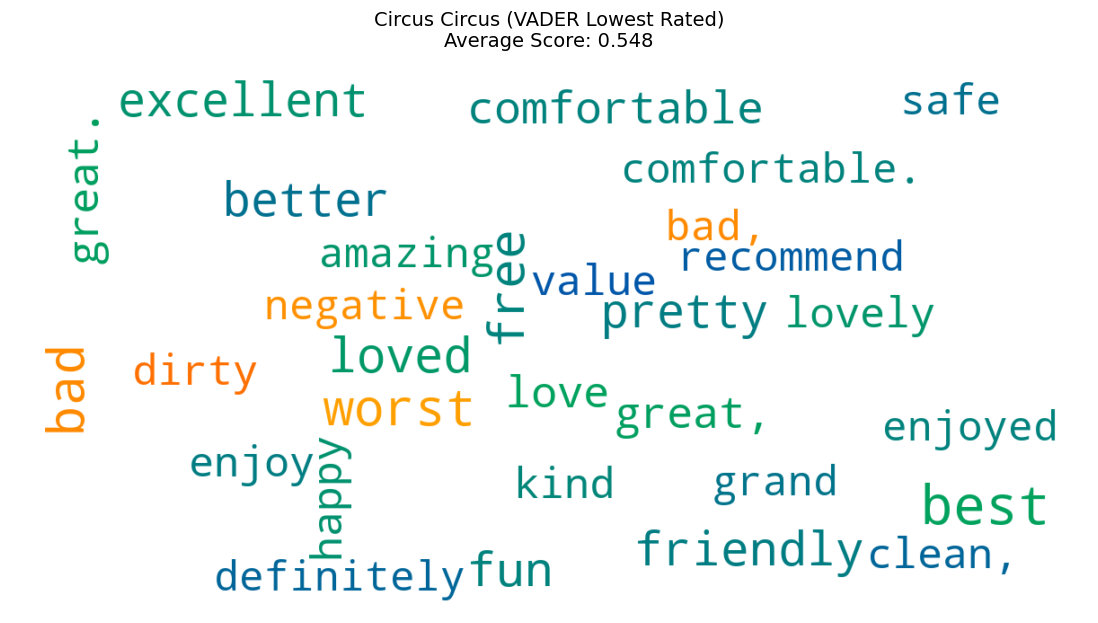


=== Consolidated Hotel Rankings ===

Hotel Rankings by All Models:
               RoBERTa_Score  RoBERTa_Rank  HotelBERT_Score  HotelBERT_Rank  VADER_Score  VADER_Rank  Review_Count  Average_Rank
Bellagio               0.657           1.0            0.695             1.0        0.878         1.0           337           1.0
Encore                 0.501           2.0            0.652             2.0        0.772         2.0           334           2.0
Bally's                0.483           3.0            0.628             3.0        0.715         3.0           324           3.0
Excalibur              0.393           4.0            0.568             4.0        0.712         4.0           334           4.0
Circus Circus          0.276           5.0            0.511             5.0        0.548         5.0           342           5.0

Saving results to Excel...


: 

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SentimentAnalyzer:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.device = self.get_device()
        print(f"Using device: {self.device}")
        
        print("Loading RoBERTa model...")
        roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
        self.roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
        self.roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
        self.roberta_model = self.roberta_model.to(self.device)
        self.roberta_model.eval()
        
        print("Loading Hotel-BERT model...")
        hotel_bert_name = "nlptown/bert-base-multilingual-uncased-sentiment"
        self.hotel_bert_tokenizer = AutoTokenizer.from_pretrained(hotel_bert_name)
        self.hotel_bert_model = AutoModelForSequenceClassification.from_pretrained(hotel_bert_name)
        self.hotel_bert_model = self.hotel_bert_model.to(self.device)
        self.hotel_bert_model.eval()
        
        print("Loading VADER analyzer...")
        self.vader = SentimentIntensityAnalyzer()

    def get_device(self):
        if torch.backends.mps.is_available():
            return torch.device("mps")
        elif torch.cuda.is_available():
            return torch.device("cuda")
        return torch.device("cpu")

    def process_roberta_batch(self, texts):
        """Process a batch of texts with RoBERTa"""
        if isinstance(texts, str):
            texts = [texts]
            
        inputs = self.roberta_tokenizer(
            texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.roberta_model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
            return (scores[:, 2] - scores[:, 0]).cpu().numpy()

    def process_hotel_bert_batch(self, texts):
        """Process a batch of texts with Hotel BERT"""
        if isinstance(texts, str):
            texts = [texts]
            
        inputs = self.hotel_bert_tokenizer(
            texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.hotel_bert_model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
            
            # Calculate weighted average for 1-5 star ratings and normalize to 0-1
            weights = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32, device=self.device)
            weighted_scores = (scores * weights.unsqueeze(0)).sum(dim=1)
            normalized_scores = (weighted_scores - 1) / 4  # Convert from 1-5 to 0-1 scale
            
            return normalized_scores.cpu().numpy()

    def analyze_texts(self, texts):
        """Analyze texts using all three models"""
        roberta_scores = []
        hotel_bert_scores = []
        vader_scores = []
        word_sentiments = {}
        
        # Process reviews in batches
        for i in tqdm(range(0, len(texts), self.batch_size), desc="Processing reviews"):
            batch_texts = texts[i:i + self.batch_size]
            
            roberta_batch = self.process_roberta_batch(batch_texts)
            hotel_bert_batch = self.process_hotel_bert_batch(batch_texts)
            vader_batch = [self.vader.polarity_scores(text)['compound'] for text in batch_texts]
            
            roberta_scores.extend(roberta_batch)
            hotel_bert_scores.extend(hotel_bert_batch)
            vader_scores.extend(vader_batch)
        
        # Get unique words and their sentiments
        print("\nCalculating word sentiments...")
        word_freq = Counter(word.lower() 
                          for text in texts 
                          for word in text.split() 
                          if len(word) > 2)
        
        # Remove words that appear less than twice
        unique_words = {word for word, freq in word_freq.items() if freq >= 2}
        
        # Process unique words in batches
        word_list = list(unique_words)
        for i in tqdm(range(0, len(word_list), self.batch_size), desc="Processing words"):
            batch_words = word_list[i:i + self.batch_size]
            
            roberta_word_scores = self.process_roberta_batch(batch_words)
            hotel_bert_word_scores = self.process_hotel_bert_batch(batch_words)
            vader_word_scores = [self.vader.polarity_scores(word)['compound'] 
                               for word in batch_words]
            
            for word, r_score, h_score, v_score in zip(batch_words, 
                                                      roberta_word_scores,
                                                      hotel_bert_word_scores,
                                                      vader_word_scores):
                word_sentiments[word] = {
                    'roberta': r_score,
                    'hotel-bert': h_score,
                    'vader': v_score
                }
        
        return np.array(roberta_scores), np.array(hotel_bert_scores), np.array(vader_scores), word_sentiments

    def create_wordcloud(self, hotel_reviews, word_sentiments, model_type, title):
        """Create word cloud using pre-calculated sentiment scores"""
        words_list = [word.lower() 
                     for review in hotel_reviews 
                     for word in review.split() 
                     if len(word) > 2]
        
        # Count word frequencies
        word_freq = Counter(words_list)
        
        # Calculate frequency percentiles for outlier removal
        freq_values = np.array(list(word_freq.values()))
        lower_threshold = np.percentile(freq_values, 1)
        upper_threshold = np.percentile(freq_values, 99)
        
        # Calculate word importance scores
        word_scores = {}
        for word, freq in word_freq.items():
            if lower_threshold <= freq <= upper_threshold and freq >= 2:
                sentiment = abs(word_sentiments.get(word, {}).get(model_type, 0))
                if sentiment > 0.05:
                    word_scores[word] = sentiment * np.log1p(freq)
        
        if not word_scores:
            print(f"Warning: No significant terms found for {title}")
            return
        
        def color_func(word, **kwargs):
            sentiment = word_sentiments.get(word, {}).get(model_type, 0)
            if sentiment > 0:
                intensity = int(min(255, abs(sentiment) * 255))
                return f"rgb(0,{intensity},{255-intensity})"
            else:
                intensity = int(min(255, abs(sentiment) * 255))
                return f"rgb({255},{intensity},0)"
        
        wordcloud = WordCloud(
            width=1200,
            height=600,
            background_color='white',
            max_words=30,
            min_font_size=10,
            max_font_size=60,
            color_func=color_func
        ).generate_from_frequencies(word_scores)
        
        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=14, pad=20)
        plt.show()
        plt.close()

def get_extreme_reviews(df, hotel_name, score_col, n=3):
    """Get top and bottom n reviews for a hotel based on score"""
    hotel_reviews = df[df['hotel'] == hotel_name]
    
    top_reviews = hotel_reviews.nlargest(n, score_col)[['Review', score_col]]
    bottom_reviews = hotel_reviews.nsmallest(n, score_col)[['Review', score_col]]
    
    return top_reviews, bottom_reviews

def main():
    # Initialize analyzer
    analyzer = SentimentAnalyzer(batch_size=32)
    
    # Read data
    print("Reading data...")
    df = pd.read_excel('/Users/humphrjk/Library/CloudStorage/OneDrive-UNTSystem/ADTA 5320/ADTA 5230/ADTA 5230/Data/hotels.xlsx')
    
    # Calculate sentiments for all reviews
    print("\nAnalyzing reviews...")
    roberta_scores, hotel_bert_scores, vader_scores, word_sentiments = analyzer.analyze_texts(df['Review'].tolist())
    
    # Add scores to dataframe
    df['roberta_sentiment'] = roberta_scores
    df['hotel_bert_sentiment'] = hotel_bert_scores
    df['vader_sentiment'] = vader_scores
    
    # Calculate correlations
    correlations = pd.DataFrame({
        'RoBERTa': [1, 
                    np.corrcoef(roberta_scores, hotel_bert_scores)[0,1],
                    np.corrcoef(roberta_scores, vader_scores)[0,1]],
        'Hotel-BERT': [np.corrcoef(hotel_bert_scores, roberta_scores)[0,1],
                      1,
                      np.corrcoef(hotel_bert_scores, vader_scores)[0,1]],
        'VADER': [np.corrcoef(vader_scores, roberta_scores)[0,1],
                 np.corrcoef(vader_scores, hotel_bert_scores)[0,1],
                 1]
    }, index=['RoBERTa', 'Hotel-BERT', 'VADER'])
    
    print("\n=== Model Correlations ===")
    print(correlations.round(3))
    
    # Calculate hotel statistics
    hotel_stats = df.groupby('hotel').agg({
        'roberta_sentiment': ['mean', 'std'],
        'hotel_bert_sentiment': ['mean', 'std'],
        'vader_sentiment': ['mean', 'std'],
        'Review': 'count'
    }).round(3)
    
    hotel_stats.columns = ['RoBERTa_Mean', 'RoBERTa_Std',
                          'HotelBERT_Mean', 'HotelBERT_Std',
                          'VADER_Mean', 'VADER_Std', 'Review_Count']
    
    # Sort by each scoring method
    roberta_sorted = hotel_stats.sort_values('RoBERTa_Mean', ascending=False)
    hotel_bert_sorted = hotel_stats.sort_values('HotelBERT_Mean', ascending=False)
    vader_sorted = hotel_stats.sort_values('VADER_Mean', ascending=False)
    
    # Print rankings and extreme reviews for each model
    print("\n=== Hotel Rankings and Extreme Reviews ===")
    model_configs = [
        ('roberta', roberta_sorted, 'roberta_sentiment', 'RoBERTa', 'RoBERTa_Mean'),
        ('hotel-bert', hotel_bert_sorted, 'hotel_bert_sentiment', 'HotelBERT', 'HotelBERT_Mean'),
        ('vader', vader_sorted, 'vader_sentiment', 'VADER', 'VADER_Mean')
    ]
    
    for model_type, sorted_stats, score_col, model_name, mean_col in model_configs:
        print(f"\n{model_name} Rankings:")
        print(sorted_stats[[mean_col, 'Review_Count']])
        
        print(f"\n{model_name} Extreme Reviews:")
        
        # For highest rated hotel
        top_hotel = sorted_stats.index[0]
        print(f"\nHighest Rated Hotel: {top_hotel}")
        top_reviews, bottom_reviews = get_extreme_reviews(df, top_hotel, score_col)
        
        print("\nTop 3 Reviews:")
        for idx, (_, row) in enumerate(top_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:200]}...")
        
        print("\nBottom 3 Reviews:")
        for idx, (_, row) in enumerate(bottom_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:200]}...")
        
        # For lowest rated hotel
        bottom_hotel = sorted_stats.index[-1]
        print(f"\nLowest Rated Hotel: {bottom_hotel}")
        top_reviews, bottom_reviews = get_extreme_reviews(df, bottom_hotel, score_col)
        
        print("\nTop 3 Reviews:")
        for idx, (_, row) in enumerate(top_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:200]}...")
        
        print("\nBottom 3 Reviews:")
        for idx, (_, row) in enumerate(bottom_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:200]}...")
        
        # Generate word clouds
        print(f"\nGenerating word clouds for {model_name}...")
        for hotel_name, rating in [(top_hotel, "Highest"), (bottom_hotel, "Lowest")]:
            hotel_reviews = df[df['hotel'] == hotel_name]['Review']
            avg_score = df[df['hotel'] == hotel_name][score_col].mean()
            title = f"{hotel_name} ({model_name} {rating} Rated)\nAverage Score: {avg_score:.3f}"
            analyzer.create_wordcloud(hotel_reviews, word_sentiments, model_type, title)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Hotel': hotel_stats.index,
        'RoBERTa_Score': hotel_stats['RoBERTa_Mean'],
        'HotelBERT_Score': hotel_stats['HotelBERT_Mean'],
        'VADER_Score': hotel_stats['VADER_Mean'],
        'Review_Count': hotel_stats['Review_Count'],
        'RoBERTa_Rank': hotel_stats.index.get_indexer(roberta_sorted.index) + 1,
        'HotelBERT_Rank': hotel_stats.index.get_indexer(hotel_bert_sorted.index) + 1,
        'VADER_Rank': hotel_stats.index.get_indexer(vader_sorted.index) + 1
    })
     # Print consolidated rankings table
    print("\n=== Consolidated Hotel Rankings ===")
    rankings_df = pd.DataFrame(index=df['hotel'].unique())
    
    for model_name, score_col in [
        ('RoBERTa', 'roberta_sentiment'),
        ('HotelBERT', 'hotel_bert_sentiment'),
        ('VADER', 'vader_sentiment')
    ]:
        # Add mean scores
        rankings_df[f'{model_name}_Score'] = df.groupby('hotel')[score_col].mean()
        
        # Add ranks
        rankings_df[f'{model_name}_Rank'] = rankings_df[f'{model_name}_Score'].rank(ascending=False, method='min')
    
    # Add review count
    rankings_df['Review_Count'] = df.groupby('hotel')['Review'].count()
    
    # Calculate average rank across all models
    rank_columns = [col for col in rankings_df.columns if col.endswith('_Rank')]
    rankings_df['Average_Rank'] = rankings_df[rank_columns].mean(axis=1)
    
    # Sort by average rank
    rankings_df = rankings_df.sort_values('Average_Rank')
    
    # Round scores to 3 decimal places
    score_columns = [col for col in rankings_df.columns if col.endswith('_Score')]
    rankings_df[score_columns] = rankings_df[score_columns].round(3)
    
    print("\nHotel Rankings by All Models:")
    print(rankings_df.to_string())
    
    # Also save this to the Excel file
    with pd.ExcelWriter('hotel_sentiment_comparison.xlsx') as writer:
        correlations.to_excel(writer, sheet_name='Model_Correlations')
        hotel_stats.to_excel(writer, sheet_name='Hotel_Statistics')
        rankings_df.to_excel(writer, sheet_name='Consolidated_Rankings')
    # Save results
    print("\nSaving results to Excel...")
    with pd.ExcelWriter('hotel_sentiment_comparison.xlsx') as writer:
        correlations.to_excel(writer, sheet_name='Model_Correlations')
        hotel_stats.to_excel(writer, sheet_name='Hotel_Statistics')
        comparison_df.to_excel(writer, sheet_name='Detailed_Comparison', index=False)
        
        # Save extreme reviews
        extreme_reviews_data = []
        for model_name, score_col in [
            ('RoBERTa', 'roberta_sentiment'),
            ('Hotel-BERT', 'hotel_bert_sentiment'),
            ('VADER', 'vader_sentiment')
        ]:
            sorted_hotels = df.groupby('hotel')[score_col].mean().sort_values(ascending=False)
            for hotel_name in [sorted_hotels.index[0], sorted_hotels.index[-1]]:
                top_reviews, bottom_reviews = get_extreme_reviews(df, hotel_name, score_col)
                extreme_reviews_data.append({
                    'Model': model_name,
                    'Hotel': hotel_name,
                    'Rating': 'Highest' if hotel_name == sorted_hotels.index[0] else 'Lowest',
                    'Average_Score': sorted_hotels[hotel_name],
                    'Top_Reviews': '\n\n'.join(top_reviews['Review']),
                    'Top_Scores': ', '.join(map(str, top_reviews[score_col].round(3))),
                    'Bottom_Reviews': '\n\n'.join(bottom_reviews['Review']),
                    'Bottom_Scores': ', '.join(map(str, bottom_reviews[score_col].round(3)))
                })
        
        pd.DataFrame(extreme_reviews_data).to_excel(writer, sheet_name='Extreme_Reviews', index=False)

    # Clean up
    if analyzer.device.type in ["mps", "cuda"]:
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()